# Algorithmic Fairness, Accountability, and Ethics, Spring 2025

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [221]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.optimize import fmin_tnc
import pandas as pd
import matplotlib.pyplot as plt

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=False)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX', # Binary value for sex
                 "DIS", # Binary value for disability
                 "VPS"] # Binary value for veteran status

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    # SEX
    sex = df["SEX"].values
    # DISABILITY
    dis = df["DIS"].values-1
    # RACE
    race = np.zeros((np.shape(df["SEX"])))
    race[df["RAC1P"]==2]=1
    race[df["RAC1P"]==1]=2
    # VETERAN
    df["VPS"]=-(df["VPS"].notnull().astype(int)-1)
    df["VPS"]=df["VPS"].fillna(0)
    vps = df["VPS"].values
    # SCHL data grouping 
    # grouping 16+17 and 22+23
    df['SCHL'].replace({17.0:16.0, 18.0:17.0, 19.0:18.0, 20.0:19.0, 21.0:20.0, 22.0:21.0, 23.0:21.0, 24.0:22.0}, inplace=True)
    # MAR data grouping
    # Grouping the not married categories
    df["MAR"].replace({3:2, 4:2, 5:2}, inplace=True)
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "MAR", "SEX", "RAC1P", "DIS", "VPS"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    # For one-hot-encoding english abilities, which we decided not to do
    #df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    # Adding an intercept column, for fitting log reg
    df_processed['Intercept']=1
    # Reorder the columns so that 'x0' becomes the first column
    df_processed = df_processed[['Intercept'] + [col for col in df_processed.columns if col != 'Intercept']]

    return df_processed, df, target, sex, race, dis, vps

data, data_original, target, groupsex, grouprace, _, _ = data_processing(acs_data, feature_names, target_name)

# Standardizing since we are fitting a logistic regression model 
# School
scaler=MinMaxScaler()
data["SCHL"]=scaler.fit_transform(data[["SCHL"]])

# Age
scaler=MinMaxScaler()
data["AGEP"]=scaler.fit_transform(data[["AGEP"]]).astype(float)

# English abilities
# Filling nan values with zero
data["ENG"]=data["ENG"].fillna(0)

# Flipping the data such that 0 is no english ability and 4 is native/professional
data["ENG"]=-(data["ENG"]-4)
scaler=MinMaxScaler()
data["ENG"]=scaler.fit_transform(data[["ENG"]]).astype(float)

# Splitting in a training and test set
X_train, X_test, y_train, y_test, groupsex_train, groupsex_test, grouprace_train, grouprace_test = train_test_split(
    data, target, groupsex, grouprace, test_size=0.2, random_state=0)

# Ensuring entries are floats for later numpy operations
X_train=X_train.astype(float)
y_train=y_train.astype(float)
X_test=X_test.astype(float)
y_test=y_test.astype(float)
#X_train = X_train.to_numpy()

C:\Users\Bruger\AppData\Local\Temp\ipykernel_14592\2835788560.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['SCHL'].replace({17.0:16.0, 18.0:17.0, 19.0:18.0, 20.0:19.0, 21.0:20.0, 22.0:21.0, 23.0:21.0, 24.0:22.0}, inplace=True)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_14592\2835788560.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the interme

In [222]:
data.columns
# We should consider grouping working class

Index(['Intercept', 'AGEP', 'ENG', 'SCHL', 'HINS1_2', 'HINS2_2', 'HINS4_2',
       'CIT_2', 'CIT_3', 'CIT_4', 'CIT_5', 'COW_2.0', 'COW_3.0', 'COW_4.0',
       'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0', 'MAR_2', 'SEX_2', 'RAC1P_2',
       'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8',
       'RAC1P_9', 'DIS_2', 'VPS_1'],
      dtype='object')

## Logistic regression model without any fairness

In [223]:
# Sigmoid function
def sigmoid(beta, X):
    return 1/(1+np.exp(-(X @ beta)))

# Logistic loss 
def logistic_loss(beta, X, y, lambda_, gamma_):
    m = len(y)
    g = sigmoid(beta, X)
    return 1/m* np.sum(-y * np.log(g) - (1-y) * np.log(1-g))

# Objective function to minimize
def objective_function(beta, X, y, lambda_, gamma_):
    lloss=logistic_loss(beta, X, y, lambda_,gamma_)
    f=0 # not including any fairness constraint yet
    l2loss=np.sum(beta**2)
    return lloss+gamma_*l2loss+lambda_*f

# Function for the given f prime
def fprime(beta, X, y, lambda_, gamma_):
    m = len(y)
    g = sigmoid(beta, X)
    return 1/m * np.dot(X.T,(g-y))+2*gamma_*beta

# The given evaluation error function
def evaluate_error(y_pred,labels_, group_):
    # amount of groups
    unique_groups = np.unique(group_)

    group_accuracy=np.zeros(unique_groups.size)

    for i in range(0,unique_groups.size):
        idx=group_==unique_groups[i]
        group_accuracy[i]=accuracy_score(y_pred[idx], labels_[idx])
    
    #group_accuracy_df = pd.Series({int(k): float(v) for k, v in group_accuracy.items()}, name="Group Accuracy")
    
    overallaccuracy = accuracy_score(y_pred, labels_)
    
    return overallaccuracy, group_accuracy

# Initial values
beta0 = np.zeros(X_train.shape[1])
lambda1=1
gamma1=1e-5


optimal_beta, nfeval, rc = fmin_tnc(func=objective_function,x0=beta0,fprime=fprime, args=(X_train,y_train, lambda1, gamma1), ftol=1e-5)
#print("Optimized beta:", optimal_beta)


y_pred_fair = np.array([True if x >=0.5 else False for x in sigmoid(optimal_beta, X_test)])



accuracy, group_acc = evaluate_error(y_pred_fair, y_test, groupsex_test)
unique_groups=np.unique(groupsex)

# Group labels
group_labels = ["Male", "Female"]

# printing group accuracies
for i in range(0,unique_groups.size):
    print(group_labels[i])
    print(group_acc[i])
    

# Convert to pandas Series
#group_acc_df = pd.Series(group_acc, name="Group Accuracy")


print("the accuracy is:", accuracy)
print("the group accuracy is:\n", group_acc)

Male
0.7804665147180059
Female
0.7418971477960242
the accuracy is: 0.7622211432806072
the group accuracy is:
 [0.78046651 0.74189715]


In [224]:
print(unique_groups)

[1 2]


In [225]:
betas={'features': X_test.columns.tolist(), 'weight':optimal_beta}
df = pd.DataFrame(data=betas)
print("Estimated betas:\n" ,df)

Estimated betas:
      features    weight
0   Intercept -4.476678
1        AGEP  3.491834
2         ENG  0.886671
3        SCHL  3.619274
4     HINS1_2 -1.065311
5     HINS2_2 -0.154251
6     HINS4_2  0.836031
7       CIT_2 -0.074670
8       CIT_3  0.061906
9       CIT_4  0.170950
10      CIT_5  0.031584
11    COW_2.0  0.099171
12    COW_3.0  0.151214
13    COW_4.0  0.190287
14    COW_5.0  0.568497
15    COW_6.0 -0.557678
16    COW_7.0  0.337733
17    COW_8.0 -1.082878
18      MAR_2 -0.499185
19      SEX_2 -0.730500
20    RAC1P_2 -0.309954
21    RAC1P_3 -0.208853
22    RAC1P_4 -0.011931
23    RAC1P_5 -0.265389
24    RAC1P_6  0.050249
25    RAC1P_7 -0.162122
26    RAC1P_8 -0.092507
27    RAC1P_9 -0.115835
28      DIS_2  0.403215
29      VPS_1 -0.112106


## Race

In [226]:
optimal_beta, nfeval, rc = fmin_tnc(func=objective_function,x0=beta0,fprime=fprime, args=(X_train,y_train, lambda1, gamma1), ftol=1e-5)

y_pred_fair = np.array([True if x >=0.5 else False for x in sigmoid(optimal_beta, X_test)])


accuracy, group_acc = evaluate_error(y_pred_fair, y_test, grouprace_test)

# Group labels
group_labels = ["White alone", "Black or African American alone", "American Indian alone", "Alaska Native alone", "AI and AN tribes or AI or AN, not specified and no other races", 
                 "Asian alone",  "Native Hawaiian and Other Pacific Islander alone", "Some Other Race alone",  "Two or More Races"]

group_labels = ["All other races", "Black or African American", "White alone"]

betas={'Group': group_labels, 'Accuracy':group_acc}
group_acc_df = pd.DataFrame(data=betas)

print("the accuracy is:", accuracy)
print("the group accuracy is:\n", group_acc_df)

the accuracy is: 0.7622211432806072
the group accuracy is:
                        Group  Accuracy
0            All other races  0.756761
1  Black or African American  0.736749
2                White alone  0.766996


In [227]:
betas={'features': X_test.columns.tolist(), 'weight':optimal_beta}
df = pd.DataFrame(data=betas)
print("Estimated betas:\n" ,df)

Estimated betas:
      features    weight
0   Intercept -4.476678
1        AGEP  3.491834
2         ENG  0.886671
3        SCHL  3.619274
4     HINS1_2 -1.065311
5     HINS2_2 -0.154251
6     HINS4_2  0.836031
7       CIT_2 -0.074670
8       CIT_3  0.061906
9       CIT_4  0.170950
10      CIT_5  0.031584
11    COW_2.0  0.099171
12    COW_3.0  0.151214
13    COW_4.0  0.190287
14    COW_5.0  0.568497
15    COW_6.0 -0.557678
16    COW_7.0  0.337733
17    COW_8.0 -1.082878
18      MAR_2 -0.499185
19      SEX_2 -0.730500
20    RAC1P_2 -0.309954
21    RAC1P_3 -0.208853
22    RAC1P_4 -0.011931
23    RAC1P_5 -0.265389
24    RAC1P_6  0.050249
25    RAC1P_7 -0.162122
26    RAC1P_8 -0.092507
27    RAC1P_9 -0.115835
28      DIS_2  0.403215
29      VPS_1 -0.112106


## Logistic regression model group fairness 

In [228]:
# Distance function discrete
def d(y_i, y_j):
    return 1 if y_i != y_j else 0

# Group fairness function
def individual_fairness(beta, X, y, group):
    n1=np.sum(group==1)
    n2=np.sum(group==2)
    # The predictions
    y_pred = np.array([True if x >=0.5 else False for x in sigmoid(optimal_beta, X_test)])
    
    # If model is linear
    #pred = X[group==1] @ beta
    
    # The target
    y1 = y[group==1]
    y2 = y[group==2]

    # Allocate space
    fairness_loss=0
    for i in range(n1):
        for j in range(n2):
            d_ij = d(y1[i], y2[j]) # distance
            fairness_loss += d_ij * (y_pred[i] - y_pred[j]) ** 2
    fairness_loss /= n1*n2
    return fairness_loss

def group_fairness(beta, X, y, group):
    n1=np.sum(group==1)
    n2=np.sum(group==2)
    # The predictions
    probs=sigmoid(beta, X)
    
    # Avoid getting double pairs i.e. (i,j)=(j,i), therefore we should get only Get only (i, j) where i < j
    i, j = np.triu_indices(len(y), k=1)  
    equal_mask = y[i] == y[j]
    equal_pairs = np.column_stack((i[equal_mask], j[equal_mask]))

    ## Provided solution from lecture
    #equal_pairs = np.argwhere(y[np.newaxis, :] == y[:, np.newaxis]) ### Check if labels are the same, distance is 1 if y[i] == y[j] and 0 if y[i] != y[j]
    #equal_pairs = equal_pairs[np.where(equal_pairs[:,0] != equal_pairs[:,1])] ### Remove the pairs where items are compared to themselves
    diff_groups = (group[equal_pairs[:,0]] != group[equal_pairs[:,1]]).astype(int) ### Find pairs where groups are different
    
    fairness_loss = diff_groups.dot((probs[equal_pairs[:,0]] - probs[equal_pairs[:,1]])**2)
    
    fairness_loss /= (n1*n2)
    return (fairness_loss)**2

# Sigmoid function
def sigmoid(beta, X):
    return 1/(1+np.exp(-(X @ beta)))

# Logistic loss
def logistic_loss(beta, X, y, lambda_, gamma_):
    m = len(y)
    g = sigmoid(beta, X)
    return 1/m* np.sum(-y * np.log(g) - (1-y) * np.log(1-g))

# Objective function
def objective_function(beta, X, y, lambda_, gamma_, group):
    lloss=logistic_loss(beta, X, y, lambda_,gamma_)
    f=group_fairness(beta, X, y, group) # can be changed with individual fairness
    l2loss=np.sum(beta**2)
    return lloss+lambda_*f+gamma_*l2loss

# Given f prime
def fprime(beta, X, y, lambda_, gamma_, group):
    m = len(y)
    g = sigmoid(beta, X)
    return 1/m * np.dot(X.T,(g-y))+2*gamma_*beta


In [229]:
mask = grouprace_train != 0 
print(len(mask))

156532


0


<>:48: SyntaxWarning: invalid escape sequence '\l'
<>:48: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Bruger\AppData\Local\Temp\ipykernel_14592\2537543916.py:48: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Accuracy for Different Values of $\lambda$", fontsize=16)


1
2
3
4
5
6
7
8
9


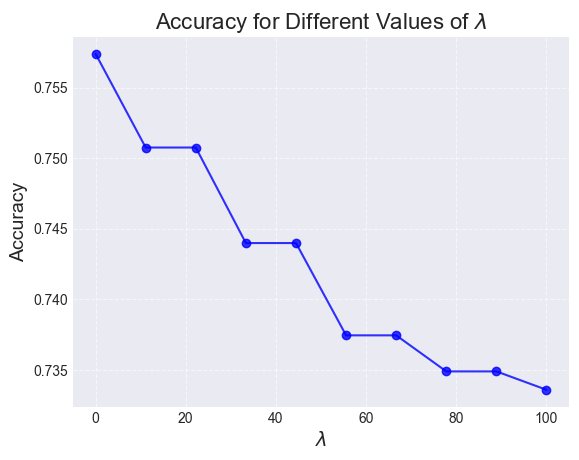

In [230]:
## Testing for the ACS dataset

# Subsampling for runtime
N = 1000 ##
X_train_sample = X_train[:N]
y_train_sample = y_train[:N]
groupsex_train_sample = groupsex_train [:N]

# Initial values
beta0 = np.zeros((np.shape(X_train)[1],1))
gamma1=1e-5

iter=10

lambda1 = np.linspace(0, 100, iter)

#Allocating space
optimal_beta = np.zeros((beta0.size,iter))
nfeval = np.zeros(iter)
rc = np.zeros(iter)
accuracy = np.zeros(iter)
group_accuracy = np.zeros((2,iter))


# Group labels
group_labels = ["Male", "Female"]

for i in range(0, 10):
    print(i)
    optimal_beta[:,i], nfeval[i], rc[i] = fmin_tnc(func=objective_function,x0=beta0,fprime=fprime, args=(X_train_sample.to_numpy(),y_train_sample, lambda1[i], gamma1, groupsex_train_sample), ftol=1e-5)

    # Calculating the predictions
    y_pred_fair = np.array([True if x >=0.5 else False for x in sigmoid(optimal_beta[:,i], X_test)])

    accuracy[i], group_accuracy[:,i] = evaluate_error(y_pred_fair, y_test, groupsex_test)

    # Convert numeric keys to labels
    
# Plot of accuracy
plt.style.use("seaborn-v0_8-darkgrid")  # Apply modern styling

# Plot with improved markers
plt.plot(lambda1, accuracy, marker='o', linestyle='-', markersize=6, color='b', alpha=0.8)

# Labels and title with improved font sizes
plt.xlabel(r"$\lambda$", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy for Different Values of $\lambda$", fontsize=16)

# Grid for readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Bruger\AppData\Local\Temp\ipykernel_14592\77031342.py:10: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Accuracy for Different Values of $\lambda$", fontsize=16)


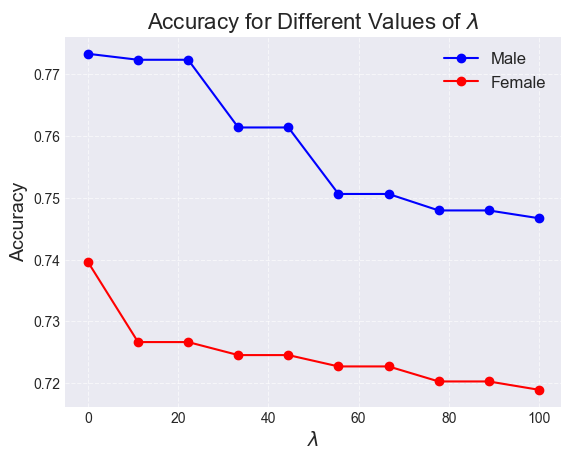

In [231]:
plt.style.use("seaborn-v0_8-darkgrid")  # Apply a modern style

# Plot with better markers and distinct colors
plt.plot(lambda1, group_accuracy[0,:], marker='o', linestyle='-', label=group_labels[0], color='b')
plt.plot(lambda1, group_accuracy[1,:], marker='o', linestyle='-', label=group_labels[1], color='r')

# Labels and title with improved font sizes
plt.xlabel(r"$\lambda$", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy for Different Values of $\lambda$", fontsize=16)

# Grid for readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

In [232]:
print(np.unique(grouprace_train))

[0. 1. 2.]


<>:56: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Bruger\AppData\Local\Temp\ipykernel_14592\2076673551.py:56: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Accuracy for Different Values of $\lambda$, group fairness race", fontsize=16)


0
1
2
3
4
5
6
7
8
9


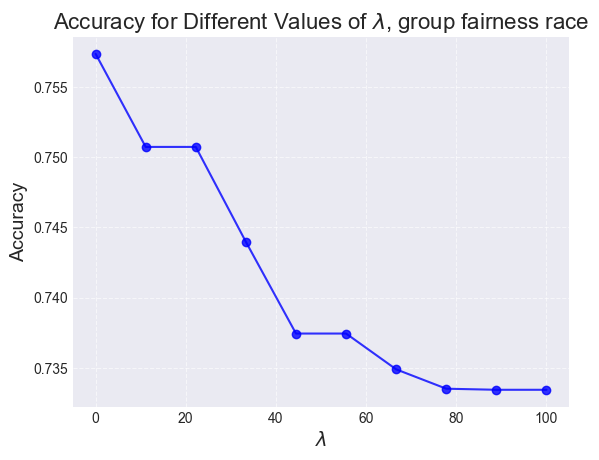

In [234]:
## Testing for the ACS dataset
## Testing for the ACS dataset

# Subsampling for runtime and group
# Assuming `group` is a separate Series or a column in X_train
mask = grouprace_train != 0  # Create a boolean mask where group is not 0

# Apply mask to extract the sub-sample
X_train_sub = X_train[mask]
y_train_sub = y_train[mask]
grouprace_train_sub = grouprace_train[mask]
N = 1000 ##
X_train_sub = X_train[:N]
y_train_sub = y_train[:N]
grouprace_train_sub = grouprace_train_sub [:N]

# Initial values
beta0 = np.zeros((np.shape(X_train)[1],1))
gamma1=1e-5

iter=10

lambda1 = np.linspace(0, 100, iter)

#Allocating space
optimal_beta = np.zeros((beta0.size,iter))
nfeval = np.zeros(iter)
rc = np.zeros(iter)
accuracy = np.zeros(iter)
group_accuracy = np.zeros((3,iter))


# Group labels
group_labels = ["Other", "Black", "White"]

for i in range(0, 10):
    print(i)
    optimal_beta[:,i], nfeval[i], rc[i] = fmin_tnc(func=objective_function,x0=beta0,fprime=fprime, args=(X_train_sub.to_numpy(),y_train_sub, lambda1[i], gamma1, grouprace_train_sub), ftol=1e-5)

    # Calculating the predictions
    y_pred_fair = np.array([True if x >=0.5 else False for x in sigmoid(optimal_beta[:,i], X_test)])

    accuracy[i], group_accuracy[:,i] = evaluate_error(y_pred_fair, y_test, grouprace_test)

    # Convert numeric keys to labels
    
# Plot of accuracy
plt.style.use("seaborn-v0_8-darkgrid")  

# Plot with improved markers
plt.plot(lambda1, accuracy, marker='o', linestyle='-', markersize=6, color='b', alpha=0.8)

# Labels and title with improved font sizes
plt.xlabel(r"$\lambda$", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy for Different Values of $\lambda$, group fairness race", fontsize=16)

# Grid for readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Bruger\AppData\Local\Temp\ipykernel_14592\1107403944.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Accuracy for Different Values of $\lambda$", fontsize=16)


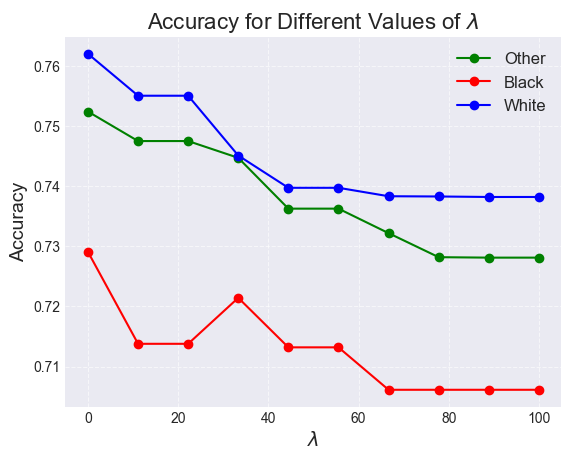

In [235]:
plt.style.use("seaborn-v0_8-darkgrid")  # Apply a modern style

# Plot with better markers and distinct colors
plt.plot(lambda1, group_accuracy[0,:], marker='o', linestyle='-', label=group_labels[0], color='g')
plt.plot(lambda1, group_accuracy[1,:], marker='o', linestyle='-', label=group_labels[1], color='r')
plt.plot(lambda1, group_accuracy[2,:], marker='o', linestyle='-', label=group_labels[2], color='b')

# Labels and title with improved font sizes
plt.xlabel(r"$\lambda$", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy for Different Values of $\lambda$", fontsize=16)

# Grid for readability
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.show()